In [34]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict, traceplot, visualize_prior, model_graph
from libs.model import HGPforecaster, PiecewiseLinearChangepoints

import theano
theano.config.compute_test_value='raise'

In [2]:
# Read in the data
INPUT_DIR = '../benchmark/m5-data'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
ss = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

We are given historic sales data in the `sales_train_validation` dataset.
- rows exist in this dataset for days d_1 to d_1913. We are given the department, category, state, and store id of the item.
- d_1914 - d_1941 represents the `validation` rows which we will predict in stage 1
- d_1942 - d_1969 represents the `evaluation` rows which we will predict for the final competition standings.

In [3]:
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


## Merging the data with real dates
- We are given a calendar with additional information about past and future dates.
- The calendar data can be merged with our days data
- From this we can find weekly and annual trends

In [4]:
# Calendar data looks like this (only showing columns we care about for now)
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,d_1,2011-01-29,NaN,NaN,NaN,NaN,0
1,d_2,2011-01-30,NaN,NaN,NaN,NaN,0
2,d_3,2011-01-31,NaN,NaN,NaN,NaN,0
3,d_4,2011-02-01,NaN,NaN,NaN,NaN,1
4,d_5,2011-02-02,NaN,NaN,NaN,NaN,1


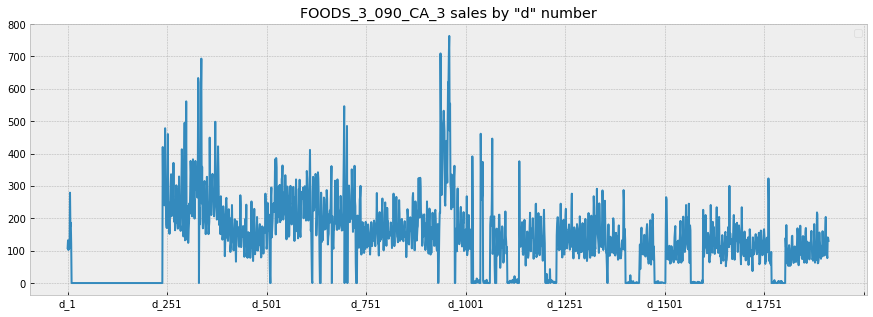

In [5]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

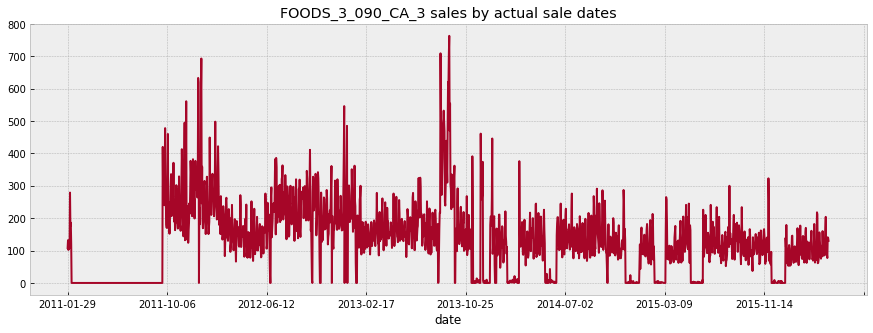

In [6]:
# Merge calendar on our items' data
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

In [7]:
stv.columns[:6]

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], dtype='object')

In [8]:
print(f'Number of unique items: {np.unique(stv.item_id).shape[0]}')
print(f'Number of unique department: {np.unique(stv.dept_id).shape[0]}')
print(f'Number of unique categories: {np.unique(stv.cat_id).shape[0]}')
print(f'Number of unique stores: {np.unique(stv.store_id).shape[0]}')
print(f'Number of unique states: {np.unique(stv.state_id).shape[0]}')

Number of unique items: 3049
Number of unique department: 7
Number of unique categories: 3
Number of unique stores: 10
Number of unique states: 3


In [9]:
# Transform column wide days to single column 

stv = stv.melt(list(stv.columns[:6]), var_name='day', value_vars=list(stv.columns[6:]), ignore_index=True)

In [10]:
# Group by the groups to consider (remove product_id as there are 3049 unique) 

stv = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id', 'day']).sum('value').reset_index()

In [11]:
days_calendar = np.concatenate((stv['day'].unique().reshape(-1,1), cal['date'][:-56].unique().reshape(-1,1)), axis=1)
df_caldays = pd.DataFrame(days_calendar, columns = ['day','Date'])

In [12]:
# Add calendar days

stv = stv.merge(df_caldays, how='left', on='day')

In [13]:
stv['Date'] = stv['Date'].astype('datetime64[ns]')
stv.dtypes

dept_id             object
cat_id              object
store_id            object
state_id            object
day                 object
value                int64
Date        datetime64[ns]
dtype: object

In [14]:
# Transform in weekly data

#stv_weekly = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id']).resample('W', on='Date')['value'].sum()

<AxesSubplot:xlabel='Date'>

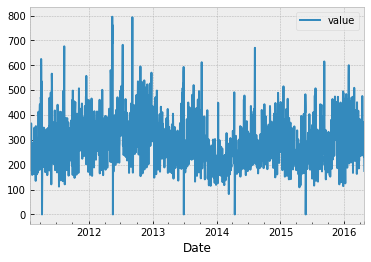

In [25]:
stv.loc[(stv.dept_id=='FOODS_1')&(stv.cat_id=='FOODS')&(stv.store_id=='CA_1')&(stv.state_id=='CA')][['Date', 'value']].set_index('Date').plot()

In [28]:
stv_fd = stv.loc[stv.Date > '2015-04-01']

In [29]:
# Build the structure to then apply the grouping transformation

stv_pivot = stv_fd.reset_index().pivot(index='Date',columns=['dept_id', 'cat_id', 'store_id', 'state_id'], values='value')
stv_pivot = stv_pivot.fillna(0)

In [30]:
stv_pivot

dept_id    FOODS_1                                              FOODS_2       \
cat_id       FOODS                                                FOODS        
store_id      CA_1 CA_2 CA_3 CA_4 TX_1 TX_2 TX_3 WI_1 WI_2 WI_3    CA_1 CA_2   
state_id        CA   CA   CA   CA   TX   TX   TX   WI   WI   WI      CA   CA   
Date                                                                           
2015-04-02     211  328  307  143  213  263  157  168  234  206     550  100   
2015-04-03     225  323  373  145  128  189  104  255  154  190     569  168   
2015-04-04     189  327  323  116  161  284  250  227  281  337     545  131   
2015-04-05     276  377  328  149  234  313  178  255  374  350     631  123   
2015-04-06     338  528  529  174  220  385  218  282  320  341     749  193   
...            ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...  ...   
2016-04-20     370  468  347  200  206  275  261  348  259  249     448  141   
2016-04-21     291  526  428  180  200  244  263  279  226  181     549  164   
2016-04-22     231  345  297  190  216  207  158  212  212  145     383   92   
2016-04-23     247  299  285  192  143  224  207  243  182  180     322   84   
2016-04-24     175  291  273  187  148  225  184  198  276  152     277   57   

dept_id                                             FOODS_3                    \
cat_id                                                FOODS                     
store_id   CA_3 CA_4 TX_1 TX_2 TX_3 WI_1  WI_2 WI_3    CA_1  CA_2  CA_3  CA_4   
state_id     CA   CA   TX   TX   TX   WI    WI   WI      CA    CA    CA    CA   
Date                                                                            
2015-04-02  736  303  357  479  508  314   642  419    1724   783  2574   881   
2015-04-03  854  318  489  655  541   66   197  728    2342  1540  2936   934   
2015-04-04  683  328  329  347  347  364  1128  562    1662  1011  2493   887   
2015-04-05  870  249  313  484  412  465   929  609    2104  1195  2727   973   
2015-04-06  979  326  341  513  336  603   765  604    2635  1527  3592  1088   
...         ...  ...  ...  ...  ...  ...   ...  ...     ...   ...   ...   ...   
2016-04-20  613  223  350  469  355  336   535  216    2858  1828  3616  1337   
2016-04-21  672  285  381  471  325  339   430  322    3175  1637  4045  1375   
2016-04-22  560  274  306  390  364  273   359  233    2006  1096  3025  1280   
2016-04-23  441  240  230  341  266  232   387  214    1790  1074  2584  1093   
2016-04-24  483  201  218  361  244  274   417  209    1822  1018  2643   937   

dept_id           ... HOBBIES_2                     HOUSEHOLD_1             \
cat_id            ...   HOBBIES                       HOUSEHOLD              
store_id    TX_1  ...      TX_2 TX_3 WI_1 WI_2 WI_3        CA_1 CA_2  CA_3   
state_id      TX  ...        TX   TX   WI   WI   WI          CA   CA    CA   
Date              ...                                                        
2015-04-02  1274  ...        29   32   25   18   12         397  424   984   
2015-04-03  1455  ...        21   35   19   17   23         463  570   687   
2015-04-04  1226  ...        34   34   22   15   24         341  426   947   
2015-04-05  1546  ...        43   43   16   18   21         414  583   992   
2015-04-06  1607  ...        48   32   25   13   27         673  857  1327   
...          ...  ...       ...  ...  ...  ...  ...         ...  ...   ...   
2016-04-20  1752  ...        50   29   57   28   36         763  943  1678   
2016-04-21  1903  ...        73   39   17   19   20         955  952  1657   
2016-04-22  1393  ...        59   27   31   29   25         655  493  1348   
2016-04-23  1175  ...        49   47   47   27   21         495  460  1232   
2016-04-24  1265  ...        60   40   45   36   21         473  517  1104   

dept_id                                       HOUSEHOLD_2                      \
cat_id                                          HOUSEHOLD                       
store_id   

<AxesSubplot:xlabel='Date'>

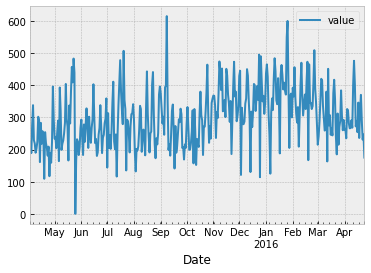

In [38]:
stv_fd.loc[(stv_fd.dept_id=='FOODS_1')&(stv_fd.cat_id=='FOODS')&(stv_fd.store_id=='CA_1')&(stv_fd.state_id=='CA')][['Date', 'value']].set_index('Date').plot()

In [31]:
groups_input = {
    'Department': [0],
    'Category': [1],
    'Store': [2],
    'State': [3]
}

In [35]:
# The dataset results from the removal of item_id (groupby by the ohter groups) and by downsampling to weekly data (the dataset was daily)

groups = generate_groups_data_flat(stv_pivot, groups_input, seasonality=7, h=30)

Number of groups: 4
	Department: 7
	Category: 3
	Store: 10
	State: 3
Total number of series: 70
Number of points per series for train: 359
Total number of points: 389
Seasonality: 7
Forecast horizon: 30


In [36]:
# Instantiate the model class
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000,
                  changepoints = 4,
                  piecewise_out=True)

In [ ]:
# Prior checks
m.prior_predictive_checks()
visualize_prior(groups, m.prior_checks, 8)

In [ ]:
# Fit and predict
m.fit_vi()
m.predict()

In [ ]:
# Visualize your predictions and credible intervals
visualize_predict(groups, m.pred_samples_predict, 8)

In [ ]:
# Print the overall resuls
results = calculate_metrics(m.pred_samples_predict, groups)
metrics_to_table(results)